# 0. Preparação do Ambiente

In [29]:
import math
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.simplefilter(action="ignore", category=Warning)

# 1. Data Loading and Cleaning

### 1.1 Pre-Cleaning

In [30]:
data = pd.read_feather('credit_scoring.ftr')

data.drop_duplicates(inplace=True)
data.drop(columns='index', inplace=True)
data.dropna(inplace=True)

In [31]:
# Calcule a contagem de valores faltantes
missing_counts = data.isnull().sum()

# Crie um DataFrame com a contagem de valores faltantes
missing_info = pd.DataFrame({'Contagem de Valores Faltantes': missing_counts})

# Imprima a informação sobre valores faltantes
print('Contagem de Valores Faltantes nos Dados:')
print(missing_info)

Contagem de Valores Faltantes nos Dados:
                       Contagem de Valores Faltantes
data_ref                                           0
sexo                                               0
posse_de_veiculo                                   0
posse_de_imovel                                    0
qtd_filhos                                         0
tipo_renda                                         0
educacao                                           0
estado_civil                                       0
tipo_residencia                                    0
idade                                              0
tempo_emprego                                      0
qt_pessoas_residencia                              0
renda                                              0
mau                                                0


### 1.2 Outliers

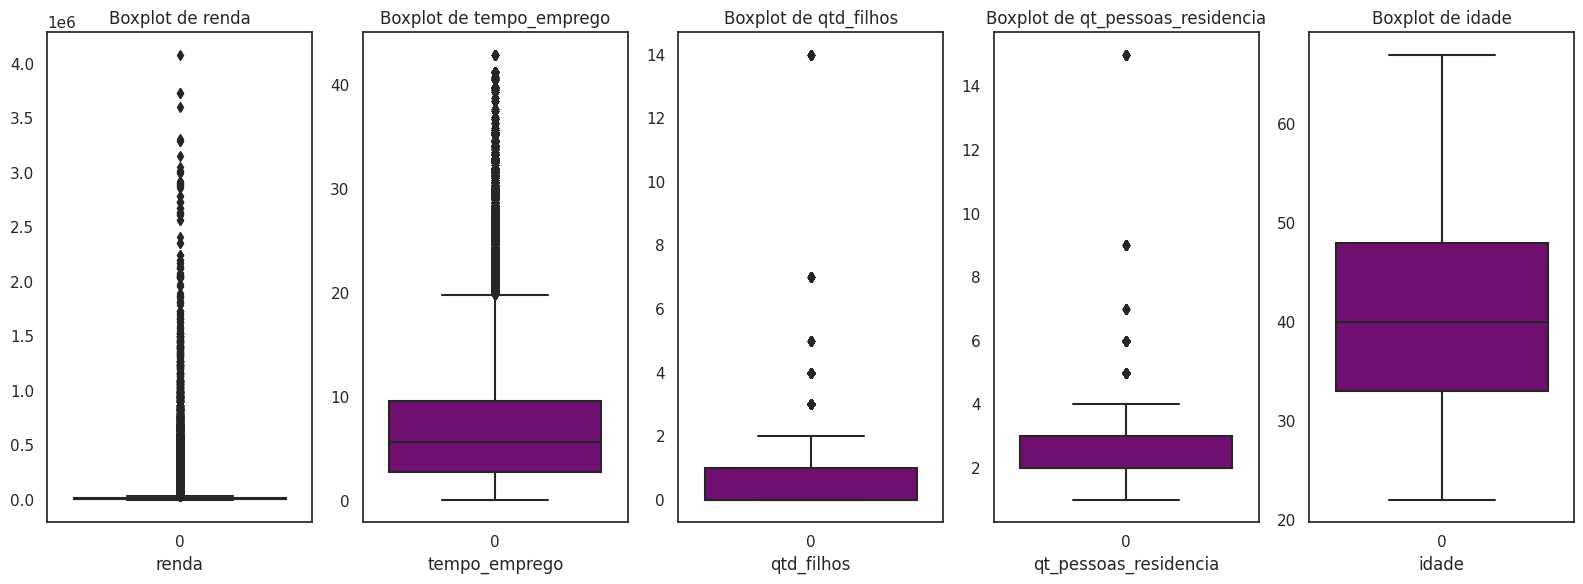

In [32]:
def criar_boxplot(data, nome_coluna, numero_subplot, cor='purple'):
    
    plt.subplot(1, 5, numero_subplot)
    sns.boxplot(data[nome_coluna], color=cor)
    plt.title(f'Boxplot de {nome_coluna}')
    plt.xlabel(nome_coluna)

def plotar_boxplots(data, colunas, cor='purple'):

    plt.figure(figsize=(16, 6))

    for i, coluna in enumerate(colunas, start=1):
        criar_boxplot(data, coluna, i, cor)

    plt.tight_layout()
    plt.show()

# Lista de colunas para criar boxplots
colunas_para_plotar = ['renda', 'tempo_emprego', 'qtd_filhos', 'qt_pessoas_residencia', 'idade']

# Chama a função para plotar os boxplots
plotar_boxplots(data, colunas_para_plotar)


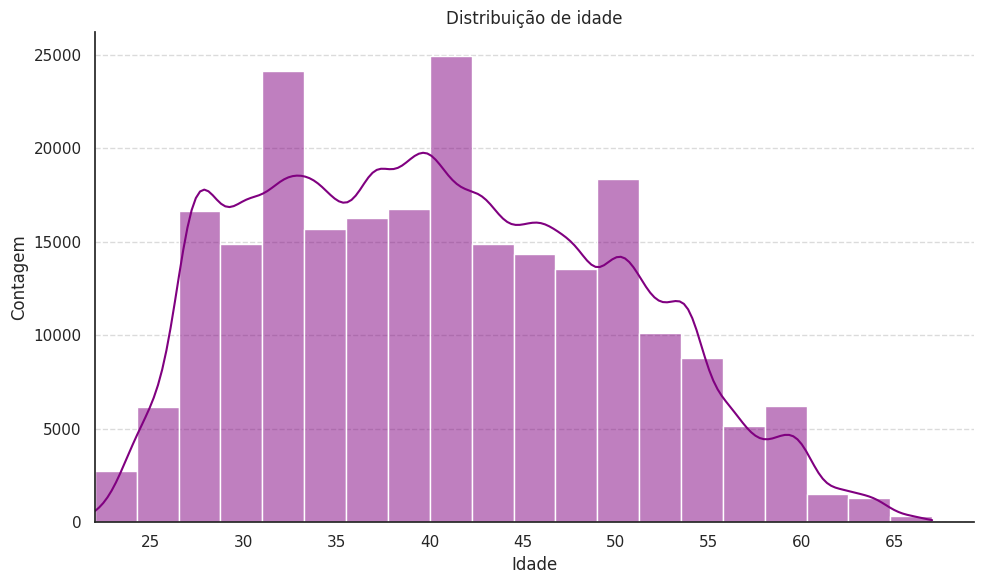

In [33]:
def plotar_histograma(data, coluna, cor='purple', bins=20, tamanho_figura=(10, 6)):

    # Define o estilo do seaborn
    sns.set(style='white')
    
    # Cria o histograma
    plt.figure(figsize=tamanho_figura)
    sns.histplot(data[coluna], color=cor, bins=bins, kde=True)
    
    # Personaliza o gráfico
    plt.title(f'Distribuição de {coluna}')
    plt.xlabel(coluna.capitalize())
    plt.ylabel('Contagem')
    plt.xticks(range(0, max(data[coluna]) + 1, 5))  
    # Remove as bordas direita e superior do gráfico
    sns.despine()
    # Adiciona linhas de grade no eixo y
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    # Define o limite mínimo do eixo x
    plt.xlim(min(data[coluna]),)
    # Ajusta o layout para evitar sobreposições e garantir que tudo seja exibido corretamente
    plt.tight_layout()
    # Exibe o gráfico
    plt.show()

# Usa a função para plotar o histograma para a coluna "idade"
plotar_histograma(data, 'idade')

### 1.3 Amostragem

In [34]:
# Obtém a data máxima no conjunto de dados
data_maxima = data['data_ref'].max()

# Calcula a data inicial para os últimos três meses
data_inicio = data_maxima - pd.DateOffset(months=3)

# Filtra os dados dos últimos três meses para validação fora do tempo (oot)
data_oot = data[(data['data_ref'] >= data_inicio) & (data['data_ref'] <= data_maxima)]

# Identifica as linhas que devem ser removidas (dados dos últimos três meses)
linhas_para_remover = data_oot.index

# Remove as linhas do dataset original para obter um dataset limpo
data_cleaned = data.drop(linhas_para_remover)

# 2. Data Exploration

### 2.1 Descritiva básica univariada

In [35]:
# Obtém a contagem de linhas para cada mês na coluna 'data_ref'
contagens_mensais = data_cleaned['data_ref'].dt.to_period('M').value_counts().sort_index()

# Define uma lista com os nomes dos meses
nomes_meses = ["Jan", "Fev", "Mar", "Abr", "Mai", "Jun", "Jul", "Ago", "Set", "Out", "Nov", "Dez"]

# Imprime o número de linhas para cada mês
print("Número de registros para cada mês:")
for periodo, contagem in contagens_mensais.items():
    print(f"{nomes_meses[periodo.month - 1]} {periodo.year}: {contagem}")

Número de registros para cada mês:
Jan 2015: 16623
Fev 2015: 16104
Mar 2015: 15560
Abr 2015: 14933
Mai 2015: 14471
Jun 2015: 14234
Jul 2015: 14143
Ago 2015: 14225
Set 2015: 14483
Out 2015: 14904
Nov 2015: 15617


### 2.2 Variaveis Qualitativas

In [36]:
# Basic univariate analysis for quantitative variables
quantitative_vars = ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']

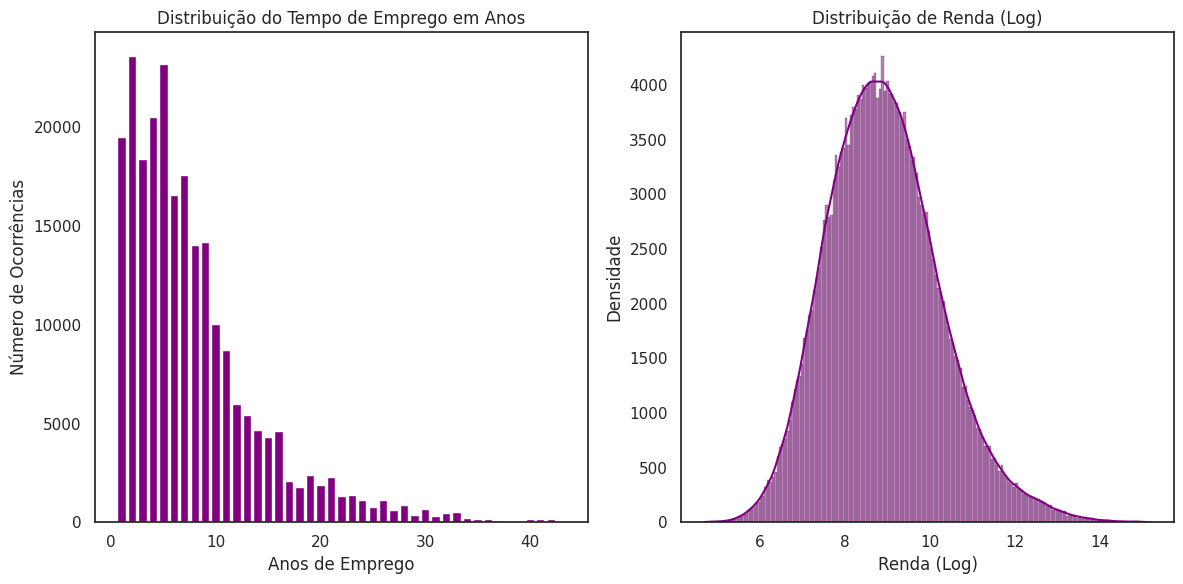

In [37]:
def plot_emprego_renda(data, col_tempo_emprego, col_renda):
    """
    Plota a distribuição do tempo de emprego e a renda logarítmica.

    Parâmetros:
    data (DataFrame): O DataFrame contendo os dados do emprego e renda.
    col_tempo_emprego (str): O nome da coluna com os dados do tempo de emprego.
    col_renda (str): O nome da coluna com os dados de renda.
    """

    # Verifica se as colunas existem no DataFrame
    if col_tempo_emprego not in data.columns or col_renda not in data.columns:
        raise ValueError("As colunas especificadas não existem no DataFrame fornecido.")

    # Preparação de dados
    data = data.dropna(subset=[col_tempo_emprego, col_renda])  # remove linhas com valores ausentes nas colunas especificadas
    data['anos_emprego'] = np.ceil(data[col_tempo_emprego])  # arredonda os valores para cima
    contagens_anos = data['anos_emprego'].value_counts().sort_index()  # conta as ocorrências
    data['renda_log'] = np.log(data[col_renda])  # aplica transformação logarítmica

    # Configuração da visualização
    plt.figure(figsize=(12, 6))

    # Primeira subplot (Distribuição do Tempo de Emprego em Anos)
    plt.subplot(1, 2, 1)
    plt.bar(contagens_anos.index, contagens_anos.values, color='purple')
    plt.xlabel('Anos de Emprego')
    plt.ylabel('Número de Ocorrências')
    plt.title('Distribuição do Tempo de Emprego em Anos')

    # Segunda subplot (Distribuição de Renda Log)
    plt.subplot(1, 2, 2)
    sns.histplot(data['renda_log'], kde=True, color='purple', edgecolor='black')
    plt.xlabel('Renda (Log)')
    plt.ylabel('Densidade')
    plt.title('Distribuição de Renda (Log)')

    # Ajusta o layout e mostra o gráfico
    plt.tight_layout()
    plt.show()


plot_emprego_renda(data, 'tempo_emprego', 'renda')

* A análise do atributo "tempo_emprego" mostra um padrão distintivo na trajetória profissional dos trabalhadores. A maioria concentra-se na faixa de 0 a 10 anos de emprego, sugerindo que grande parte está em fases iniciais de suas carreiras. Este fenômeno pode ser reflexo de uma alta rotatividade no mercado ou da entrada constante de novatos no campo profissional. Em contraste, é menos comum encontrar profissionais com mais de 20 anos de atuação. Estes, possivelmente, são os veteranos, líderes ou especialistas em suas respectivas áreas, cuja expertise é especialmente valorizada pelas empresas. A predominância de profissionais menos experientes, em comparação com os mais experientes, indica uma distribuição inclinada: com alta concentração em inícios de carreira e declínio gradual em experiências mais longevas. Esse perfil pode ter implicações significativas na dinâmica do mercado e nas perspectivas de avanço na carreira.

* O gráfico de densidade exibe a distribuição da renda após a transformação logarítmica, com o eixo x representando os valores logarítmicos da renda e o eixo y indicando a densidade desses valores. Valores com picos mais altos no gráfico denotam faixas de renda mais comuns na amostra.

* A avaliação da distribuição da renda, após a transformação logarítmica, destaca uma notável simetria. A curva de densidade apresenta-se balanceada, com um pico marcante próximo a $8000,00. Tal simetria indica que os valores de renda se distribuem de forma homogênea em torno da média, sinalizando um equilíbrio na distribuição de renda. No entanto, é crucial observar que, mesmo com esta simetria central, a distribuição tem uma extensão considerável para rendas acima de $1200000,00. Essa extensão sugere a presença de rendas atípicas ou excepcionalmente altas, divergentes do conjunto principal de dados. Esses valores elevados podem representar indivíduos ou famílias com rendimentos significativamente altos, acrescentando uma variabilidade adicional à distribuição.

### 2.3 Variaveis Quantitivas

In [38]:
# Basic univariate analysis for categorical variables
categorical_vars = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia', 'mau']

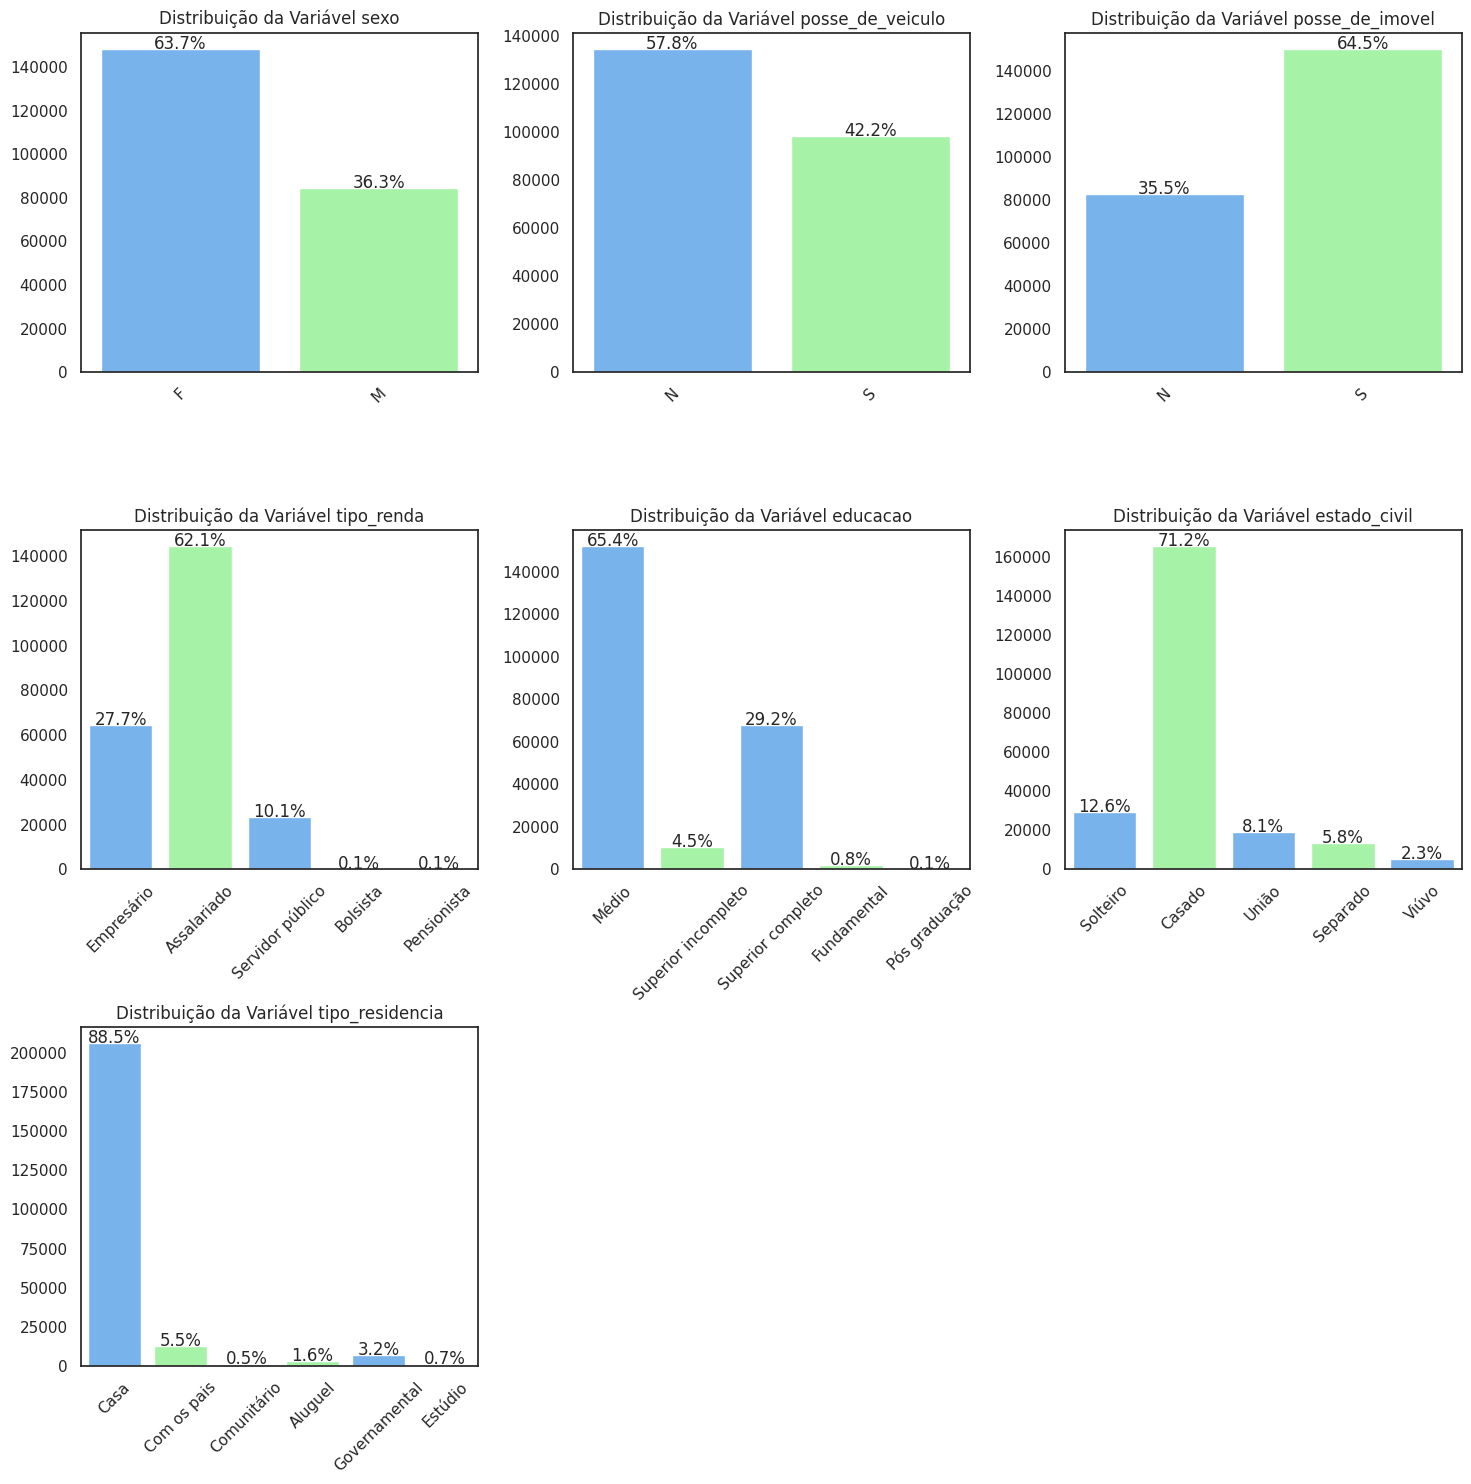

In [39]:
def plot_descricao_univariada(ax, feature: str):
    # Define uma paleta de cores personalizada
    colors = ["#66b3ff", "#99ff99"]

    # Plota um gráfico de barras (countplot) para a variável especificada
    sns.countplot(x=feature, data=data, palette=colors, ax=ax)

    # Define títulos para os eixos e para o gráfico
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(f'Distribuição da Variável {feature}')

    # Rotaciona os rótulos do eixo x para melhorar a visualização
    ax.tick_params(axis='x', rotation=45)

    # Adiciona as porcentagens acima de cada barra do gráfico
    total = len(data[feature])
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2, height + 3, f'{height/total:.1%}', ha="center")

    # Ajusta o layout para garantir que tudo seja exibido corretamente
    plt.tight_layout()

def generate_bi_report():
    # Configura o tamanho geral da figura
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))

    # Lista de colunas para serem plotadas
    colunas = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia']

    # Loop para criar os subplots
    for i, coluna in enumerate(colunas):
        ax = axes[i//3, i%3]
        plot_descricao_univariada(ax, coluna)

    # Remova o subplot vazio (no caso de um grid 3x3 com 7 gráficos)
    axes[2, 1].axis('off')
    axes[2, 2].axis('off')

    # Mostra a figura
    plt.show()

# Chame a função para gerar o relatório
generate_bi_report()


### 2.4 Perfil Demográfico e Socioeconômico do Grupo

Idade: Com uma média de 41 anos, o grupo exibe uma distribuição etária extensa.

Renda: A média salarial se situa em 8 mil reais anuais, demonstrando um espectro diversificado de condições financeiras.

Gênero: As mulheres são predominantes, constituindo 63% da amostra, enquanto os homens representam os 33% remanescentes.

Mobilidade: Uma escolha marcante é evidente: 58% optaram por não ter um veículo.

Moradia: Um terço, equivalente a 36%, não tem propriedade imobiliária, sinalizando uma variedade de escolhas habitacionais.

Educação: Com 65% do grupo tendo concluído o ensino médio, observa-se um padrão educacional mediano.

Estado Civil: A composição majoritariamente casada, 71% da amostra.

Essas peculiaridades sublinham a pluralidade e a complexidade deste conjunto, ilustrando diferentes fases de vida e uma ampla gama de decisões financeiras e pessoais.

### 2.5 Descritiva Bivariada

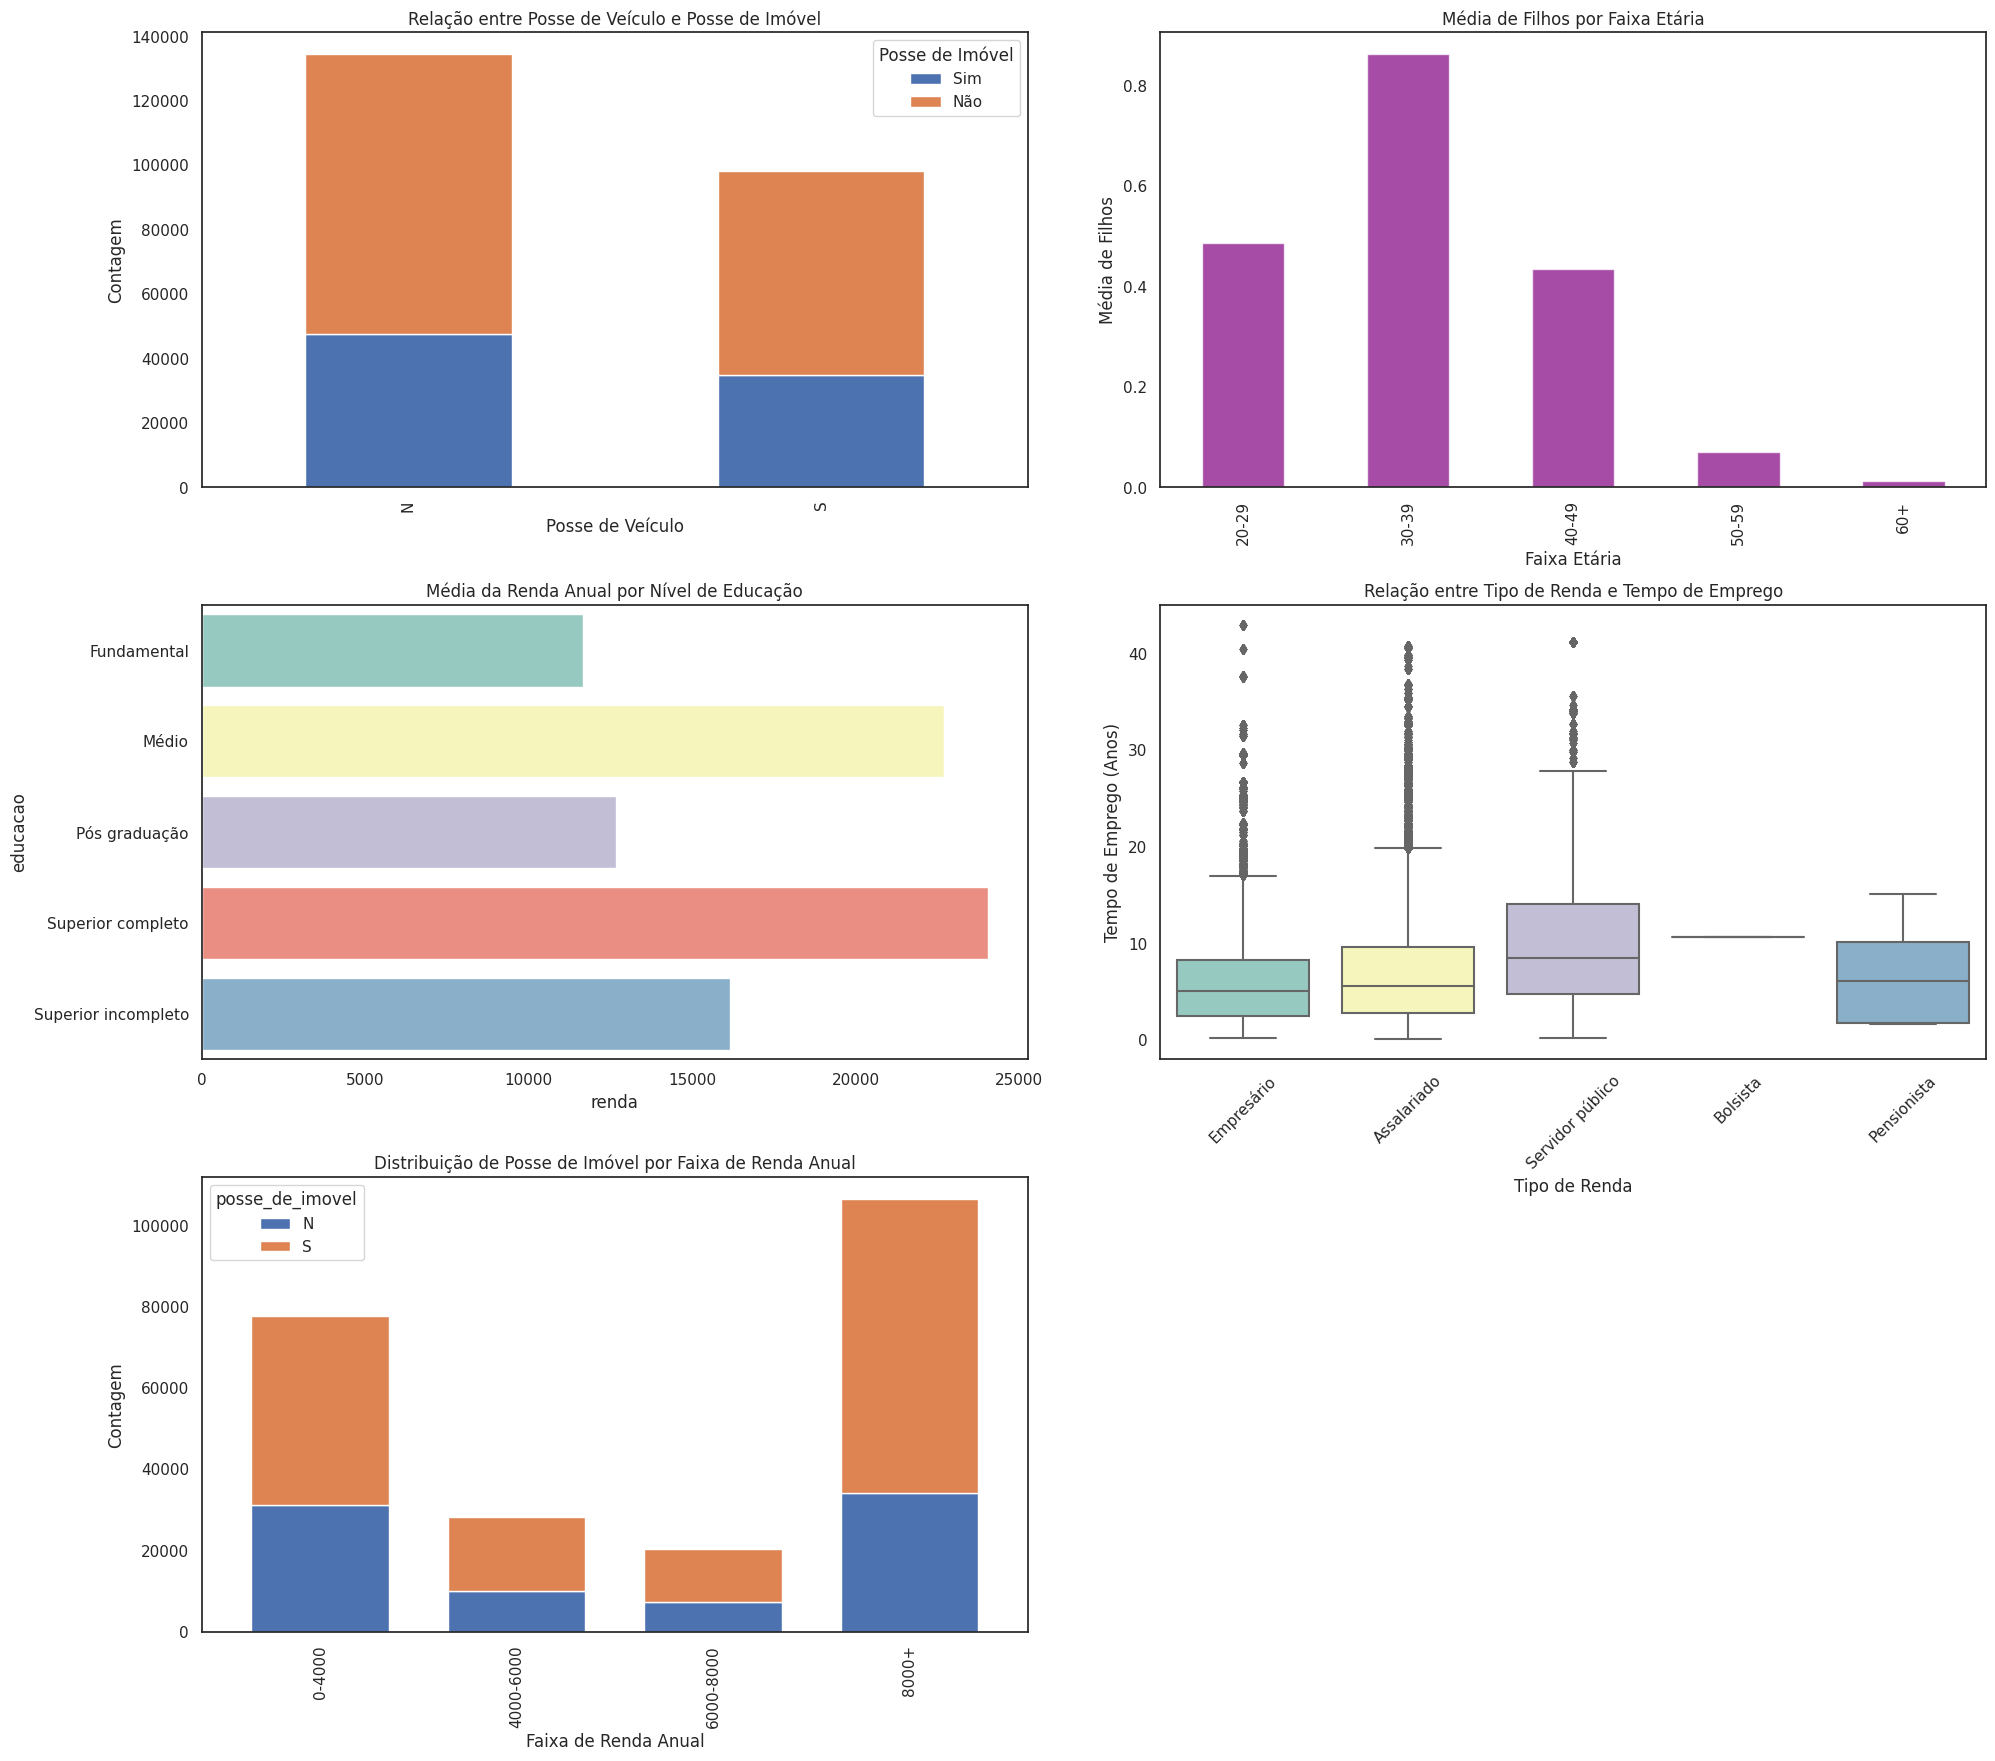

In [40]:
def plot_analises_comparativas(data):
    """
    Cria uma série de gráficos baseados no DataFrame fornecido.

    Parâmetros:
    data (DataFrame): Um DataFrame contendo as colunas necessárias.
    """

    # Verificar se todas as colunas necessárias estão presentes no DataFrame
    colunas_necessarias = ['posse_de_veiculo', 'posse_de_imovel', 'idade', 'qtd_filhos', 'educacao', 'renda', 'tipo_renda', 'tempo_emprego']
    for col in colunas_necessarias:
        if col not in data.columns:
            raise ValueError(f"Falta a coluna '{col}' no DataFrame fornecido.")

    # Configurar subplots
    fig, axs = plt.subplots(3, 2, figsize=(20, 18))
    fig.tight_layout(pad=5.0)

    # Gráfico 1: Relação entre Posse de Veículo e Posse de Imóvel
    cross_tab = pd.crosstab(data['posse_de_veiculo'], data['posse_de_imovel'])
    cross_tab.plot(kind='bar', stacked=True, ax=axs[0, 0])
    axs[0, 0].set_title('Relação entre Posse de Veículo e Posse de Imóvel')
    axs[0, 0].set_xlabel('Posse de Veículo')
    axs[0, 0].set_ylabel('Contagem')
    axs[0, 0].legend(title='Posse de Imóvel', labels=['Sim', 'Não'])

    # Gráfico 2: Média de Filhos por Faixa Etária
    limites = [20, 30, 40, 50, 60, 70]
    faixas_etarias = ["20-29", "30-39", "40-49", "50-59", "60+"]
    data['faixa_etaria'] = pd.cut(data['idade'], bins=limites, labels=faixas_etarias, right=False)
    media_filhos_por_faixa = data.groupby('faixa_etaria')['qtd_filhos'].mean()
    media_filhos_por_faixa.plot(kind='bar', color='purple', alpha=0.7, ax=axs[0, 1])
    axs[0, 1].set_title('Média de Filhos por Faixa Etária')
    axs[0, 1].set_xlabel('Faixa Etária')
    axs[0, 1].set_ylabel('Média de Filhos')

    # Gráfico 3: Média da Renda Anual por Nível de Educação
    media_renda_por_educacao = data.groupby('educacao')['renda'].mean().reset_index()
    sns.barplot(x='renda', y='educacao', data=media_renda_por_educacao, palette='Set3', ax=axs[1, 0])
    axs[1, 0].set_title('Média da Renda Anual por Nível de Educação')

    # Gráfico 4: Relação entre Tipo de Renda e Tempo de Emprego
    sns.boxplot(x='tipo_renda', y='tempo_emprego', data=data, palette='Set3', ax=axs[1, 1])
    axs[1, 1].set_title('Relação entre Tipo de Renda e Tempo de Emprego')
    axs[1, 1].set_xlabel('Tipo de Renda')
    axs[1, 1].set_ylabel('Tempo de Emprego (Anos)')
    axs[1, 1].tick_params(axis='x', rotation=45)

    # Gráfico 5: Distribuição de Posse de Imóvel por Faixa de Renda Anual
    faixas_renda = [0, 4000, 6000, 8000, float('inf')]
    categorias_renda = ['0-4000', '4000-6000', '6000-8000', '8000+']
    data['faixa_renda'] = pd.cut(data['renda'], bins=faixas_renda, labels=categorias_renda, right=False)
    tabela_cruzada = pd.crosstab(data['faixa_renda'], data['posse_de_imovel'])
    tabela_cruzada.plot(kind='bar', stacked=True, edgecolor='white', width=0.7, ax=axs[2, 0])
    axs[2, 0].set_title('Distribuição de Posse de Imóvel por Faixa de Renda Anual')
    axs[2, 0].set_xlabel('Faixa de Renda Anual')
    axs[2, 0].set_ylabel('Contagem')

    # Removendo o gráfico vazio
    axs[2, 1].axis('off')

    plt.show()

plot_analises_comparativas(data)

#### Tempo de Emprego vs. Idade vs. Renda

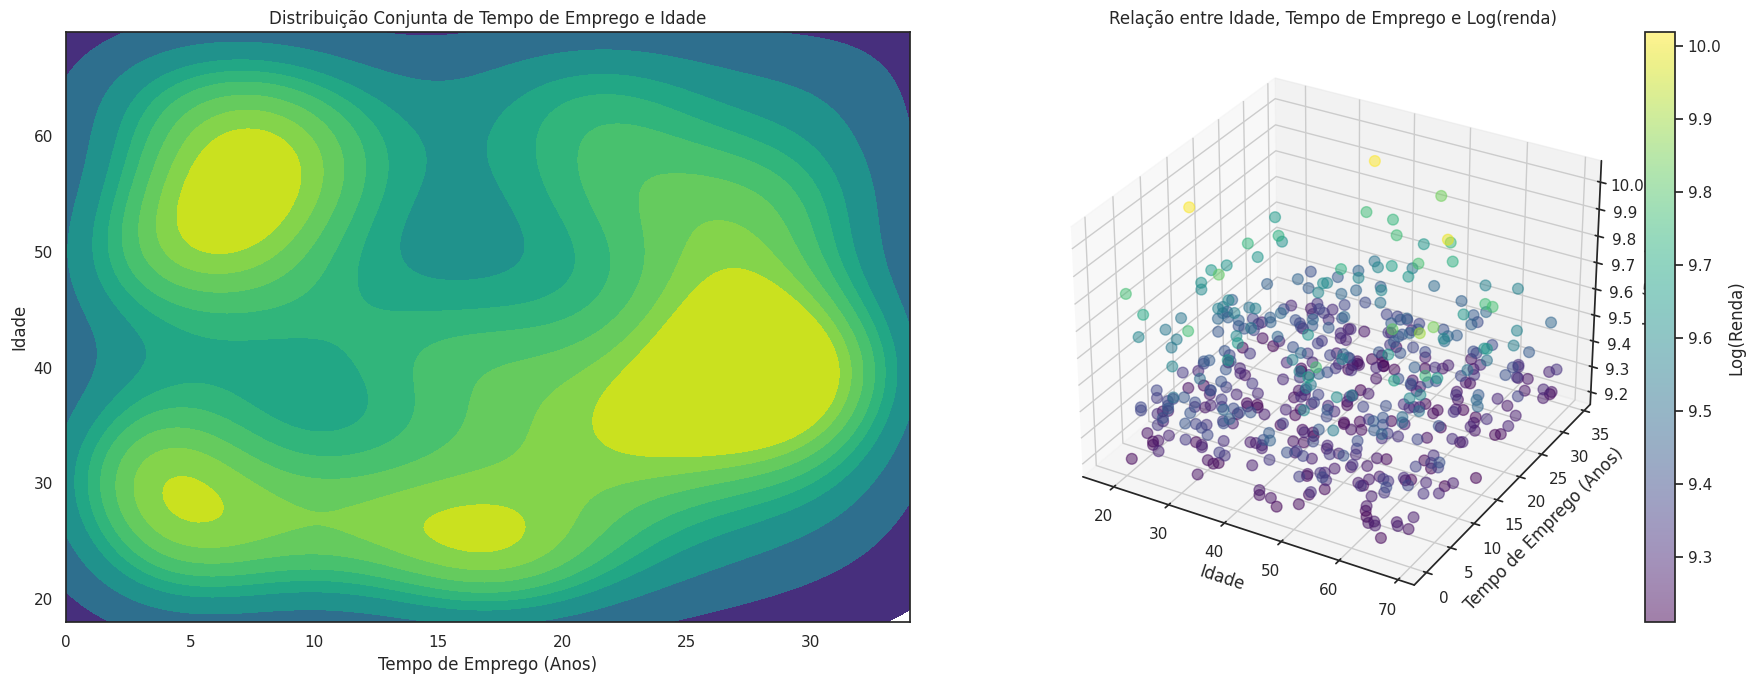

In [50]:
def plot_distribuicoes_conjuntas(data, coluna_tempo_emprego, coluna_idade, coluna_renda, titulo1='', titulo2='', cmap='viridis'):
    # Verificação das colunas no DataFrame
    for col in [coluna_tempo_emprego, coluna_idade, coluna_renda]:
        if col not in data.columns:
            raise ValueError(f"A coluna '{col}' não está presente no DataFrame.")

    # Criando uma figura
    fig = plt.figure(figsize=(18, 7))

    # Criando o primeiro subplot para o KDE plot
    ax1 = fig.add_subplot(1, 2, 1)
    sns.kdeplot(
        data=data, 
        x=coluna_tempo_emprego, 
        y=coluna_idade, 
        cmap=cmap, 
        fill=True, 
        thresh=0.05, 
        ax=ax1
    )

    ax1.set_xlim(data[coluna_tempo_emprego].min(), data[coluna_tempo_emprego].max())
    ax1.set_ylim(data[coluna_idade].min(), data[coluna_idade].max())
    ax1.set_xlabel('Tempo de Emprego (Anos)')
    ax1.set_ylabel('Idade')
    ax1.set_title(titulo1 or 'Distribuição Conjunta de Tempo de Emprego e Idade')

    # Calculando o logaritmo da renda
    data['log_renda'] = np.log(data[coluna_renda])

    # Criando o segundo subplot para o scatter plot
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    cores = data['log_renda']
    scatter = ax2.scatter(
        data[coluna_idade],
        data[coluna_tempo_emprego],
        data['log_renda'],
        c=cores,
        cmap=cmap,
        marker='o',
        alpha=0.5,
        s=60
    )

    # Configurando a barra de cores e seu rótulo
    cbar = fig.colorbar(scatter, ax=ax2, pad=0.02)
    cbar.set_label('Log(Renda)')

    # Configurando os rótulos dos eixos e o título
    ax2.set_xlabel('Idade')
    ax2.set_ylabel('Tempo de Emprego (Anos)')
    ax2.set_zlabel('Log(Renda)')
    ax2.set_title(titulo2 or 'Relação entre Idade, Tempo de Emprego e Log(Renda)')

    # Ajustando os espaçamentos
    plt.tight_layout()
    plt.show()

plot_distribuicoes_conjuntas(data, 'tempo_emprego', 'idade', 'renda', 'Distribuição Conjunta de Tempo de Emprego e Idade', 'Relação entre Idade, Tempo de Emprego e Log(renda)')


As cores mais claras são de maior incidência.

# 3. Data Modeling

In [42]:
data_cleaned.drop(columns='data_ref', inplace=True)
renda = data_cleaned['renda']

#### 3.1 Ordinal Mapping

O mapeamento ordinal refere-se à transformação de variáveis categóricas ordinais em valores numéricos, de forma que a ordem das categorias seja mantida. Esse processo permite que algoritmos de aprendizado de máquina compreendam e utilizem informações de ordem inerentes a tais categorias.

In [43]:
data_encoded = data_cleaned.copy()
# Calculate the logarithm of the 'renda' column
data_encoded['log_renda'] = np.log(data_encoded['renda'] + 1)  # Adding 1 to avoid logarithm of zero

ordinal_mappings = {
    'sexo': {'F': 0, 'M': 1},
    'posse_de_veiculo': {'N': 0, 'S': 1},
    'posse_de_imovel': {'N': 0, 'S': 1},
    'tipo_renda': {
        'Empresário': 0,
        'Assalariado': 1,
        'Servidor público': 2,
        'Bolsista': 3,
        'Pensionista': 4
    },
    'educacao': {
        'Fundamental': 0,
        'Médio': 1,
        'Superior incompleto': 2,
        'Superior completo': 3,
        'Pós graduação': 4
    },
    'estado_civil': {
        'Solteiro': 0,
        'Casado': 1,
        'União': 2,
        'Separado': 3,
        'Viúvo': 4
    },
    'tipo_residencia': {
        'Aluguel': 0,
        'Com os pais': 1,
        'Comunitário': 2,
        'Casa': 3,
        'Estúdio': 4,
        'Governamental': 5
    },
    'mau': {
        False: 0,
        True: 1
    }
}


# Calculate the logarithm of the 'renda' column
data_encoded['log_renda'] = np.log(data_encoded['renda'] + 1)  # Adding 1 to avoid logarithm of zero
data_encoded.drop(columns='renda', inplace=True)

# Apply ordinal encoding to the specified columns
for column, mapping in ordinal_mappings.items():
    data_encoded[column + '_encoded'] = data_encoded[column].map(mapping)

# Drop the original categorical columns
data_encoded.drop(columns=list(ordinal_mappings.keys()), inplace=True)


#### 3.2 Regressão logística

In [44]:
from sklearn.decomposition import PCA
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.covariance import EllipticEnvelope  # para detecção de outliers

# Suponha que data seja o seu dataframe

# Dividindo os dados em treino e teste
X = data_encoded.drop('mau_encoded', axis=1)
y = data_encoded['mau_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Remoção de outliers
outliers_removal = EllipticEnvelope(contamination=0.1)

# Agora, removemos os outliers do conjunto de treinamento antes de prosseguir
X_train_cleaned = outliers_removal.fit_predict(X_train)
X_train = X_train[X_train_cleaned != -1]
y_train = y_train[X_train_cleaned != -1]

# Configuração do PCA para manter 90% da variância
pca = PCA(n_components=0.9)

# Usando FeatureUnion para combinar PCA e StandardScaler
# Aqui, estamos aplicando PCA e, em seguida, escalonamento. Isso implica que estamos escalonando os componentes principais resultantes.
process_and_union = FeatureUnion([
    ("pca", pca),
    ("std_scaler", StandardScaler())
])

# Criando a nova pipeline com FeatureUnion
pipeline = Pipeline([
    ('features', process_and_union),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Aplicando a validação cruzada
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')

# Treinando o modelo usando a pipeline
pipeline.fit(X_train, y_train)

# Fazendo previsões
y_pred = pipeline.predict(X_test)

# Avaliando o modelo
classification_rep = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# Apresentação dos Resultados

## Relatório de Classificação
print("Relatório de Classificação:")
print(classification_rep, '\n')

## Acurácia
print("\nAcurácia no Conjunto de Teste: {:.2f}%".format(accuracy * 100))


Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93     28546
           1       0.49      0.03      0.06      4514

    accuracy                           0.86     33060
   macro avg       0.68      0.51      0.49     33060
weighted avg       0.82      0.86      0.81     33060
 


Acurácia no Conjunto de Teste: 86.33%


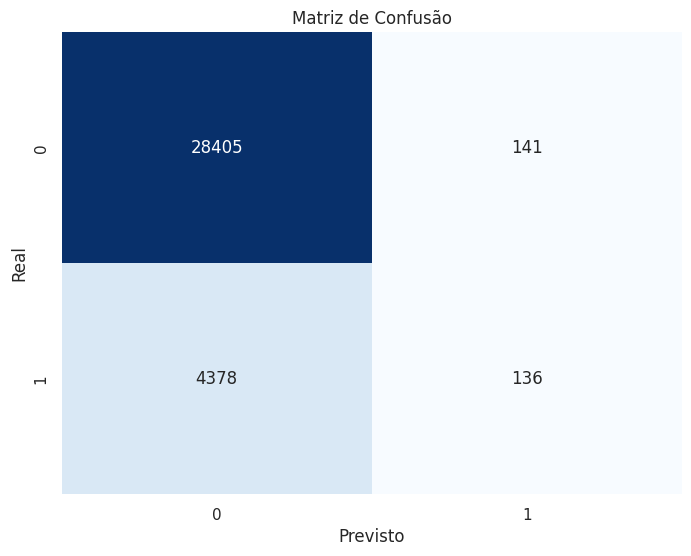

In [45]:
from sklearn.metrics import confusion_matrix

# Avaliando o modelo
y_pred = pipeline.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)

# Plotar a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

#### 3.3 Amostragem 'Out of Time'

In [46]:
# Edição dos dados para o ordinal mapping

# Calculate the logarithm of the 'renda' column
data_oot['log_renda'] = np.log(data_oot['renda'] + 1)  # Adding 1 to avoid logarithm of zero
data_oot.drop(columns='renda', inplace=True)
data_oot.drop(columns='data_ref', inplace=True)

# Apply ordinal encoding to the specified columns
for column, mapping in ordinal_mappings.items():
    data_oot[column + '_encoded'] = data_oot[column].map(mapping)

# Drop the original categorical columns
data_oot.drop(columns=list(ordinal_mappings.keys()), inplace=True)

In [47]:
# Suponha que data_oot_encoded seja a sua amostra fora do tempo já preparada
X_oot = data_oot.drop('mau_encoded', axis=1)
y_oot = data_oot['mau_encoded']

# Fazendo previsões na amostra fora do tempo
y_oot_pred = pipeline.predict(X_oot)

# Avaliando o modelo na amostra fora do tempo
classification_rep_oot = classification_report(y_oot, y_oot_pred)
accuracy_oot = accuracy_score(y_oot, y_oot_pred)

# Apresentação dos Resultados para a amostra fora do tempo

## Relatório de Classificação
print("Relatório de Classificação (OOT):")
print(classification_rep_oot, '\n')

## Acurácia
print("\nAcurácia no Conjunto OOT: {:.2f}%".format(accuracy_oot * 100))

Relatório de Classificação (OOT):
              precision    recall  f1-score   support

           0       0.77      0.96      0.86     51086
           1       0.48      0.12      0.19     16347

    accuracy                           0.75     67433
   macro avg       0.63      0.54      0.52     67433
weighted avg       0.70      0.75      0.70     67433
 


Acurácia no Conjunto OOT: 75.48%


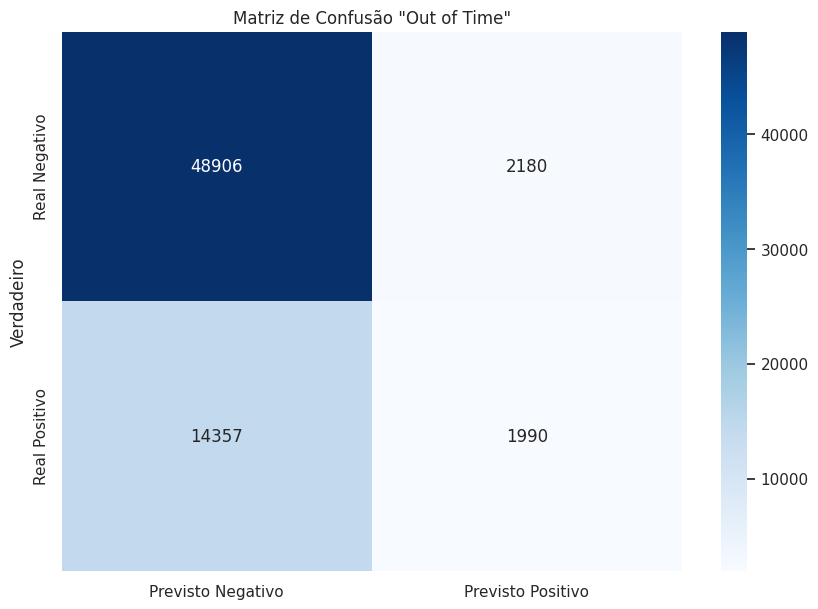

In [48]:
# Construindo a matriz de confusão
conf_matrix = confusion_matrix(y_oot, y_oot_pred)

# Visualizando a matriz de confusão
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['Previsto Negativo', 'Previsto Positivo'],
            yticklabels=['Real Negativo', 'Real Positivo'])
plt.ylabel('Verdadeiro')
plt.xlabel('')
plt.title('Matriz de Confusão "Out of Time"')
plt.show()

#### 3.4 Salvando o modelo

In [49]:
import pickle

# Salvando o modelo para um arquivo usando pickle
with open('final_model.pkl', 'wb') as model_file:
    pickle.dump(pipeline, model_file)

# Quando você quiser carregar o modelo novamente:
# with open('final_model.pkl', 'rb') as model_file:
#     loaded_model = pickle.load(model_file)
# y_pred_loaded = loaded_model.predict(X_test)


# 4. Uma abordagem diferente: Pycaret

In [76]:
# install full version
!pip install pycaret --user



[notice] A new release of pip is available: 23.2.1 -> 23.3
[notice] To update, run: python -m pip install --upgrade pip


In [72]:
!pip install pandas==1.3.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 35.7 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... error
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> [983 lines of output]
      Ignoring numpy: markers 'python_version == "3.7" and (platform_machine != "arm64" or platform_system != "Darwin") and platform_machine != "aarch64"' don't match your environment
      Ignoring numpy: markers 'python_version == "3.8" and (platform_machine != "arm64" or platform_system != "Darwin") and platform_machine != "aarch64"' don't match your environment
      Ignoring numpy: markers 'python_version == "3.7" and platform_machine == "aarch64"' don't match your environment
      Ignoring numpy: markers 'python_version == "3.8" and platform_machine == "aarch64"' don't match your environment
      Ignoring numpy: markers 'python_version == "3.8" and platform_machine == "arm64" and platform_sy

In [77]:
from pycaret.classification import *

# Suponha que data seja o seu dataframe e você já realizou todas as preparações e limpezas necessárias.

# Dividindo os dados em treino e teste (vamos usar o PyCaret para isso)
data = data_encoded  # Seu dataframe pré-processado

# Inicializando o ambiente do PyCaret
# O setup() é onde o PyCaret entende e estabelece o tipo de problema e dados com os quais está lidando.
clf1 = setup(data, target = 'mau_encoded', session_id=123, silent=True, html=False, log_experiment=False)

# Se já sabe que quer usar LightGBM, pode criar diretamente um modelo desse tipo
lightgbm = create_model('lightgbm')

# treinando o modelo e salvando como final
final_lightgbm = finalize_model(lightgbm)

# Você pode avaliar o modelo usando diferentes gráficos e métricas através do PyCaret.
# Por exemplo:
plot_model(final_lightgbm, plot = 'confusion_matrix')

# Para fazer previsões em um novo conjunto de dados (suponha que seja X_test):
predictions = predict_model(final_lightgbm, data = X_test)  # X_test deve incluir todas as colunas de entrada, excluindo a coluna alvo

# O DataFrame 'predictions' agora conterá as previsões junto com as colunas originais.

# Para salvar o modelo para uso futuro, o PyCaret usa o joblib internamente, mas você pode usar pickle se preferir.
save_model(final_lightgbm, 'lightgbm_final_model')


ModuleNotFoundError: No module named 'pandas.io.formats.style'